# Combine all the predictions, and map uncertainty

Ran an ensemble of predictions, now we need to compute the ensemble median and the uncertainty range.

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import odc.geo.xr
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask
from _percentile import xr_quantile


In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200453495808 due to system memory limit of 95.00 GiB
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configurati

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39331,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:42361,Total threads: 24
Dashboard: /proxy/34607/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:39343,


## Analysis Parameters

In [3]:
model_var = 'GPP'
base = '/g/data/os22/chad_tmp/AusEFlux/'
years = [str(i) for i in range(2003,2023)]
predictions_folder= f'{base}results/predictions/ensemble/historical/{model_var}/'

#metadata for export
full_name = 'Gross Primary Productivity'
version = 'v1.2'
units = 'gC/m2/month'

### Predictions paths

In [4]:
files = os.listdir(predictions_folder)
pred_filepaths = [predictions_folder+i for i in files if i.endswith('.nc')]
len(pred_filepaths)

30

## Quickly plot the results to inspect

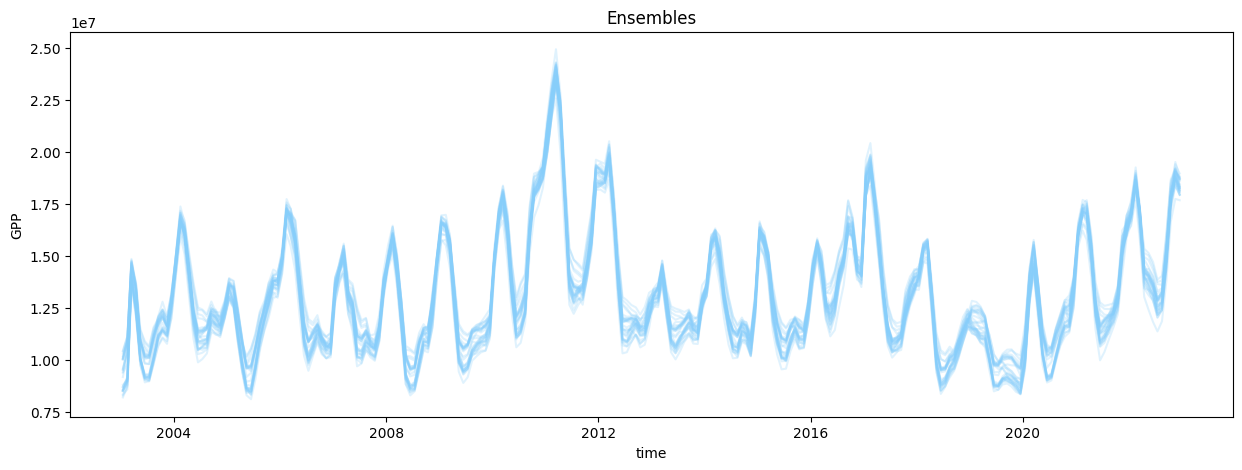

In [5]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))

i=0
for pred in pred_filepaths:
    print("  {:02}/{:02}\r".format(i + 1, len(range(0, len(pred_filepaths)))), end="")
    ds=xr.open_dataarray(pred, chunks=dict(x=1050, y=680, time=1))
    ds.sum(['x','y']).compute().plot(ax=ax, alpha=0.25, c='lightskyblue')
    i+=1 

plt.title('Ensembles');

## Find median and interquantile range

In [6]:
arrs=[]
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred, chunks=dict(x=1000, y=1000, time=1)) #680, longitude=1050, time=1
    arrs.append(ds.rename(pred[-8:-3]))
    
ds = xr.merge(arrs)
ds = ds.to_array()

ds = xr_quantile(ds, quantiles=[0.05, 0.50, 0.95], nodata=np.nan)
ds = ds.rename({'band':model_var+'_quantiles'}).to_array().squeeze().drop('variable')
ds.attrs['nodata']=np.nan
ds

<xarray.DataArray (quantile: 3, time: 240, y: 680, x: 840)>
dask.array<getitem, shape=(3, 240, 680, 840), dtype=float32, chunksize=(1, 1, 680, 840), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2022-12-15
  * y            (y) float32 -10.02 -10.07 -10.12 ... -43.88 -43.92 -43.97
  * x            (x) float32 112.0 112.1 112.1 112.2 ... 153.8 153.9 153.9 154.0
  * quantile     (quantile) float64 0.05 0.5 0.95
Attributes:
    nodata:   nan

In [7]:
%%time
ds = ds.compute()

CPU times: user 28.5 s, sys: 3.04 s, total: 31.6 s
Wall time: 1min 15s


### Plot the results

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=(15, 5))
# ds.sel(quantile=0.05).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.05')
# ds.sel(quantile=0.50).sum(['x','y']).plot(ax=ax, alpha=0.5, c='darkgreen', label='median')
# ds.sel(quantile=0.95).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.95')

# ax.legend()
# plt.title('Uncertanity modelling, quantiles of ensembles')

## Save to netcdf

Add attritbutes and naming convention ready for productions

Export as annual files in a folder - this will help with running an annual update each year.

In [8]:
ds = ds.rename(full_name)
ds.attrs['units'] = units

ds = ds.to_dataset(dim='quantile').rename({0.05:model_var+'_5th_percentile',
                                           0.5:model_var+'_median',
                                           0.95:model_var+'_95th_percentile',
                                           'x':'longitude', 'y':'latitude'})
ds = assign_crs(ds, crs='EPSG:4326')
ds

<xarray.Dataset>
Dimensions:              (time: 240, latitude: 680, longitude: 840)
Coordinates:
    spatial_ref          int32 4326
  * time                 (time) datetime64[ns] 2003-01-15 ... 2022-12-15
  * latitude             (latitude) float32 -10.02 -10.07 ... -43.92 -43.97
  * longitude            (longitude) float32 112.0 112.1 112.1 ... 153.9 154.0
Data variables:
    GPP_5th_percentile   (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_median           (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_95th_percentile  (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    nodata:   nan
    units:    gC/m2/month

In [9]:
for year in years:
    xx = ds.sel(time=year)
    xx.to_netcdf(f'{base}results/AusEFlux/{model_var}/AusEFlux_{version}_{model_var}_5km_quantiles_{year}.nc')